In [1]:
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.cuda.is_available()

True

In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')

CUDA is available. Training on GPU ...


In [4]:
num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


In [26]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [27]:
#prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

In [28]:
#specify the image classes
classes=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [48]:
for images, labels in trainloader:
    print(images.shape)
    break

torch.Size([20, 3, 32, 32])


In [51]:
# run the test harness for evaluating a model

def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    #define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY, batch_size=64)
    #fit model
    steps = int(trainX.shape[0]/64)
    history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=400, validation_data=(testX, testY), verbose=0)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

        

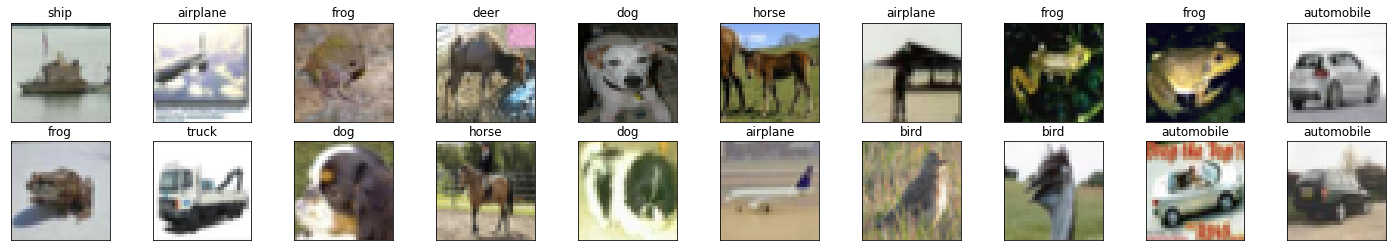

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) # convert from Tensor image
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
#plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

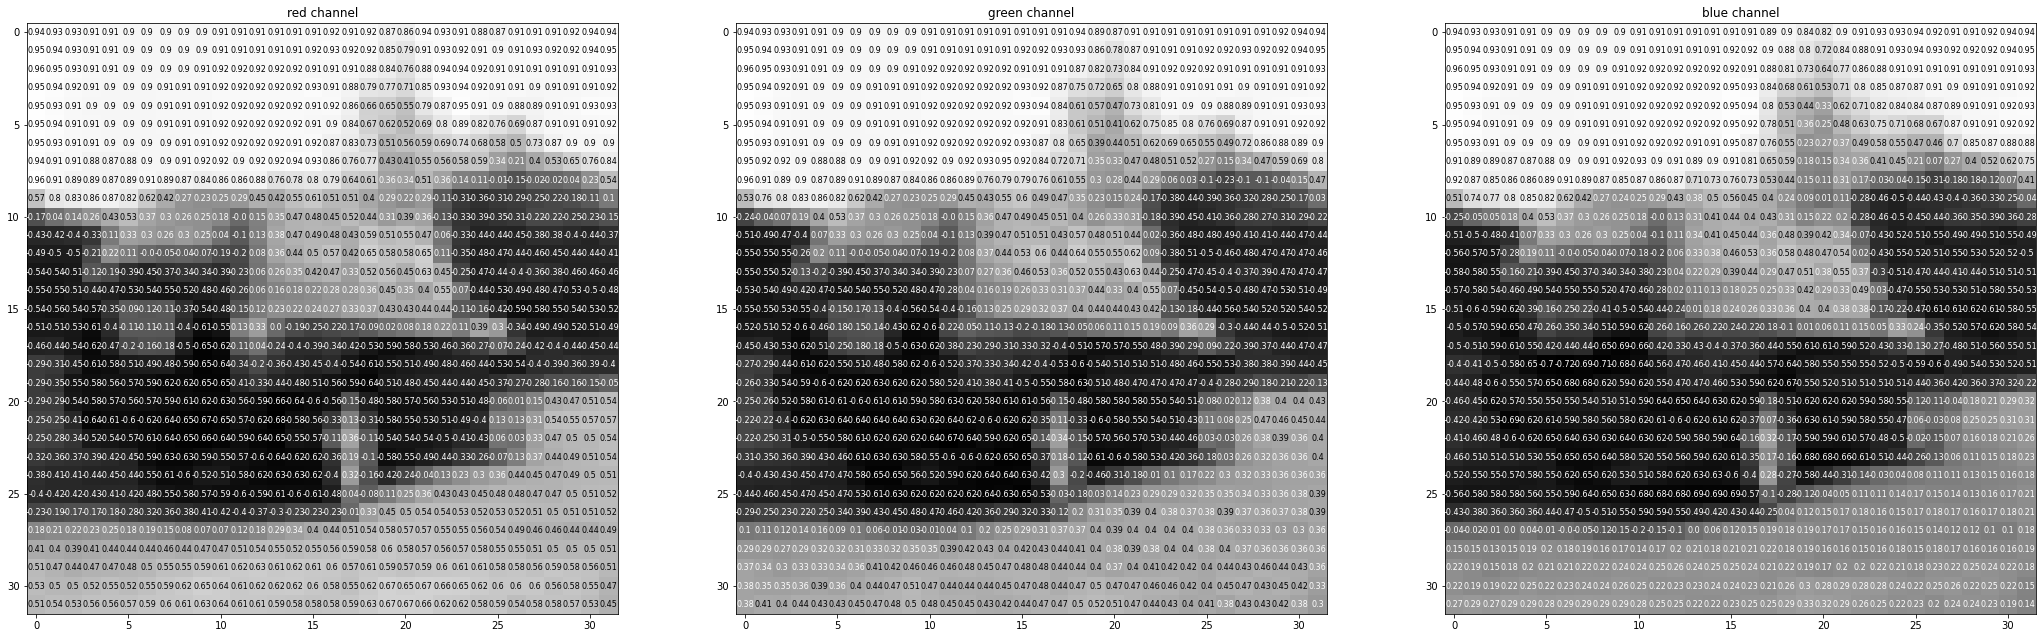

In [34]:
# looking into details of normalized RGB

rgb_img = np.squeeze(images[19])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [53]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        # TODO: Define your model
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        
        # Max pooling layer (divides image size by 2)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        
        # Dropout
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        # Sequence of convolutional and max pooling layers
        #3*32*32
        x = self.pool(F.relu(self.conv1(x)))
        #16*32*32-> 16*16*16
        x = self.pool(F.relu(self.conv2(x)))
        #32*16*16-> 32*8*8
        x = self.pool(F.relu(self.conv3(x)))
        #64*8*8->64*4*4
        # Flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # Dropout layer
        x = self.dropout(x)
        # 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Dropout layer
        x = self.dropout(x)
        # 2nd hidden layer
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [54]:
!pip install torchsummary

In [55]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 512]         524,800
           Dropout-9                  [-1, 512]               0
           Linear-10                   [-1, 64]          32,832
           Linear-11                   [-1, 10]             650
Total params: 581,866
Trainable params: 581,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [57]:
#  loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [59]:
# number of epochs to train the model
n_epochs = 30

train_losslist=[]
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losslist.append(train_loss)   
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.863851 	Validation Loss: 0.821315
Validation loss decreased (inf --> 0.821315).  Saving model ...
Epoch: 2 	Training Loss: 0.833281 	Validation Loss: 0.808422
Validation loss decreased (0.821315 --> 0.808422).  Saving model ...
Epoch: 3 	Training Loss: 0.812777 	Validation Loss: 0.801104
Validation loss decreased (0.808422 --> 0.801104).  Saving model ...
Epoch: 4 	Training Loss: 0.795428 	Validation Loss: 0.765567
Validation loss decreased (0.801104 --> 0.765567).  Saving model ...
Epoch: 5 	Training Loss: 0.771430 	Validation Loss: 0.778864
Epoch: 6 	Training Loss: 0.754283 	Validation Loss: 0.755588
Validation loss decreased (0.765567 --> 0.755588).  Saving model ...
Epoch: 7 	Training Loss: 0.734571 	Validation Loss: 0.763004
Epoch: 8 	Training Loss: 0.713825 	Validation Loss: 0.752970
Validation loss decreased (0.755588 --> 0.752970).  Saving model ...
Epoch: 9 	Training Loss: 0.700544 	Validation Loss: 0.721654
Validation loss decreased (0.752970 --> 0.

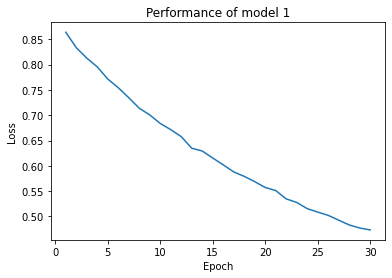

In [60]:
plt.plot(range(1,n_epochs+1),train_losslist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of model 1')
plt.show()

In [97]:
# track test loss
test_loss=0.0

class_correct= list(0. for i in range(10))
class_total= list(0. for i in range(10))


model.eval()
for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item()*data.size(0)
        #convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        #compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
#average test loss
test_loss=test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2s/%2d)' % 
              (classes[i], 100 * class_correct[i] / class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
         print('Test Accuracy of %5s: N/A (no training example)' % (classes[i]))

            
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct)/np.sum(class_total),np.sum(class_correct),np.sum(class_total)))

Test Loss: 0.664897

Test Accuracy of airplane: 77% (777.0/1000)
Test Accuracy of automobile: 87% (877.0/1000)
Test Accuracy of  bird: 64% (640.0/1000)
Test Accuracy of   cat: 59% (598.0/1000)
Test Accuracy of  deer: 78% (780.0/1000)
Test Accuracy of   dog: 66% (666.0/1000)
Test Accuracy of  frog: 83% (836.0/1000)
Test Accuracy of horse: 81% (813.0/1000)
Test Accuracy of  ship: 89% (896.0/1000)
Test Accuracy of truck: 83% (835.0/1000)

Test Accuracy (Overall): 77% (7718/10000)


C:\Users\ULIS\AppData\Local\Temp\ipykernel_11836\362892921.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_title("{} ({})".format(classes[correct[idx]], classes[labels[idx]]),


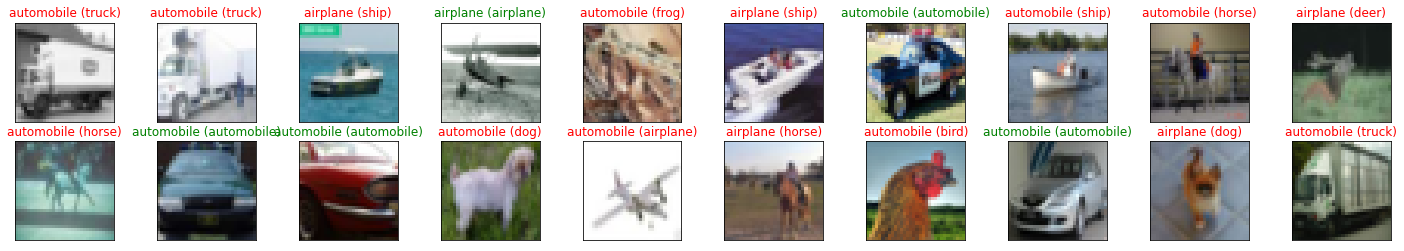

In [65]:
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[correct[idx]], classes[labels[idx]]),
                 color=("green" if correct[idx]==labels[idx].item() else "red"))
